# Motor Imagery EEG Classification using CSP and Machine Learning

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yourusername/reponame/blob/main/EEG_Classification.ipynb)

**A comprehensive pipeline for motor imagery EEG signal classification using Common Spatial Patterns (CSP) and machine learning models.**

## Table of Contents
1. [Setup & Installation](#setup)
2. [Data Loading](#data-loading)
3. [Core Functions](#core-functions)
4. [Signal Visualization](#signal-visualization)
5. [Data Preprocessing](#data-preprocessing)
6. [Model Training & Evaluation](#model-training)
7. [Results](#results)


<a name="setup"></a>
## 1. Setup & Installation

In [1]:
import scipy.io
import numpy as np
import scipy.signal
from sklearn import svm
from numpy import linalg
from matplotlib import mlab
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

<a name="data-loading"></a>
## 2. Data Loading

In [2]:
!wget http://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip
!unzip BCICIV_1_mat.zip

--2025-02-02 23:07:37--  http://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip
Resolving bbci.de (bbci.de)... 130.149.80.149
Connecting to bbci.de (bbci.de)|130.149.80.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip [following]
--2025-02-02 23:07:37--  https://bbci.de/competition/download/competition_iv/BCICIV_1_mat.zip
Connecting to bbci.de (bbci.de)|130.149.80.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252211988 (241M) [application/zip]
Saving to: ‘BCICIV_1_mat.zip’

BCICIV_1_mat.zip    100%[===================>] 240.53M  27.1MB/s    in 9.7s    

2025-02-02 23:07:47 (24.9 MB/s) - ‘BCICIV_1_mat.zip’ saved [252211988/252211988]

Archive:  BCICIV_1_mat.zip
  inflating: BCICIV_calib_ds1a.mat   
  inflating: BCICIV_calib_ds1b.mat   
  inflating: BCICIV_calib_ds1c.mat   
  inflating: BCICIV_calib_ds1d.mat   
  inflating: BCICIV_

In [3]:
persons = ['a','b','c','d','e','f','g']
all_signals = []
for i in persons:
  all_signals.append(scipy.io.loadmat('/content/BCICIV_calib_ds1'+str(i)+'.mat',struct_as_record=True))
all_signals = np.array(all_signals)

<a name="core-functions"></a>
## 3. Core Functions

In [4]:
def psd(trials): # A Power Spectral Density (PSD) is the measure of signal's power content versus frequency

    ntrials = trials.shape[2]
    trials_PSD = np.zeros((nchannels, (nsamples//2) + 1, ntrials))

    for trial in range(ntrials):
        for ch in range(nchannels):
            (PSD, freqs) = mlab.psd(trials[ch,:,trial], NFFT=int(nsamples), Fs=sample_rate)
            trials_PSD[ch, :, trial] = PSD.ravel()

    return trials_PSD, freqs

In [5]:
def plot_psd(trials_PSD, freqs, chan_ind, chan_lab=None, maxy=None):

    plt.figure(figsize=(12,5))

    nchans = len(chan_ind)

    # Maximum of 3 plots per row
    nrows = int(np.ceil(nchans / 3))
    ncols = min(3, nchans)

    # Enumerate over the channels
    for i,ch in enumerate(chan_ind):
        # Figure out which subplot to draw to
        plt.subplot(nrows,ncols,i+1)

        # Plot the PSD for each class
        for cl in cl_lab:
            plt.plot(freqs, np.mean(trials_PSD[cl][ch,:,:], axis=1), label=cl)

        # All plot decoration below...

        plt.xlim(1,30)

        if maxy != None:
            plt.ylim(0,maxy)

        plt.grid()

        plt.xlabel('Frequency (Hz)')

        if chan_lab == None:
            plt.title('Channel %d' % (ch+1))
        else:
            plt.title(chan_lab[i])

        plt.legend()

    plt.tight_layout()

In [6]:
def bandpass(trials, lo, hi, sample_rate): #We will follow a classic BCI design by Blankertz et al. [1] where they use the logarithm of the variance of the signal in a certain frequency band as a feature for the classifier.

    a, b = scipy.signal.iirfilter(6, [lo/(sample_rate/2.0), hi/(sample_rate/2.0)])

    ntrials = trials.shape[2]
    trials_filt = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_filt[:,:,i] = scipy.signal.filtfilt(a, b, trials[:,:,i], axis=1)

    return trials_filt

In [7]:
def plot_logvar(trials):
    plt.figure(figsize=(12,5))

    x0 = np.arange(nchannels)
    x1 = np.arange(nchannels) + 0.4

    y0 = np.mean(trials[cl1], axis=1)
    y1 = np.mean(trials[cl2], axis=1)

    plt.bar(x0, y0, width=0.5, color='b')
    plt.bar(x1, y1, width=0.4, color='r')

    plt.xlim(-0.5, nchannels+0.5)

    plt.gca().yaxis.grid(True)
    plt.title('log-var of each channel/component')
    plt.xlabel('channels/components')
    plt.ylabel('log-var')
    plt.legend(cl_lab)

In [8]:
def cov(trials):
    ''' Calculate the covariance for each trial and return their average '''
    ntrials = trials.shape[2]
    covs = [ trials[:,:,i].dot(trials[:,:,i].T) / nsamples for i in range(ntrials) ]
    return np.mean(covs, axis=0)

def whitening(sigma):
    ''' Calculate a whitening matrix for covariance matrix sigma. '''
    U, l, _ = linalg.svd(sigma)
    return U.dot( np.diag(l ** -0.5) )

def csp(trials_r, trials_f):
    '''

    The Common Spatial Pattern (CSP) algorithm is an effective and popular method for classifying 2-class motor imagery electroencephalogram (EEG) data, but its effectiveness depends on the subject-specific frequency band

    Calculate the CSP transformation matrix W.
    arguments:
        trials_r - Array (channels x samples x trials) containing right hand movement trials
        trials_f - Array (channels x samples x trials) containing foot movement trials
    returns:
        Mixing matrix W
    '''
    cov_r = cov(trials_r)
    cov_f = cov(trials_f)
    P = whitening(cov_r + cov_f)
    B, _, _ = linalg.svd( P.T.dot(cov_f).dot(P) )
    W = P.dot(B)
    return W

def apply_mix(W, trials):
    ''' Apply a mixing matrix to each trial (basically multiply W with the EEG signal matrix)'''
    ntrials = trials.shape[2]
    trials_csp = np.zeros((nchannels, nsamples, ntrials))
    for i in range(ntrials):
        trials_csp[:,:,i] = W.T.dot(trials[:,:,i])
    return trials_csp

In [9]:
def plot_scatter(left, right):
    plt.figure()
    plt.scatter(left[0,:], left[-1,:], color='b')
    plt.scatter(right[0,:], right[-1,:], color='r')
    plt.xlabel('Last component')
    plt.ylabel('First component')
    plt.legend(cl_lab)

<a name="signal-visualization"></a>
## 4. Signal Visualization

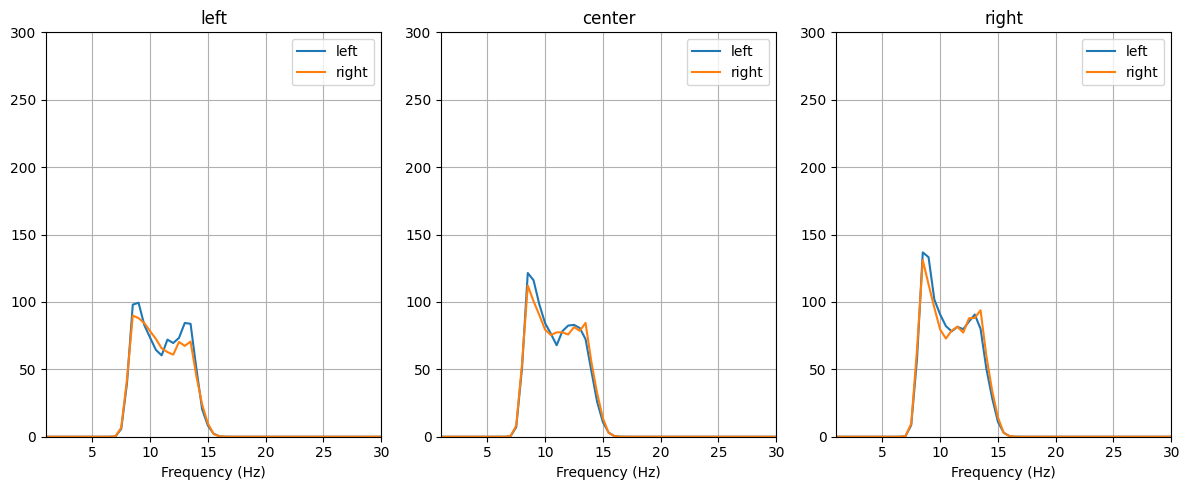

In [10]:
m = all_signals[3]
sample_rate = m['nfo']['fs'][0][0][0][0]
EEG = m['cnt'].T
nchannels, nsamples = EEG.shape

channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
event_onsets = m['mrk'][0][0][0]
event_codes = m['mrk'][0][0][1]
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
cl1 = cl_lab[0]
cl2 = cl_lab[1]
nclasses = len(cl_lab)
nevents = len(event_onsets)

temp = {}

win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate))

nsamples = len(win)

for cl, code in zip(cl_lab, np.unique(event_codes)):

    cl_onsets = event_onsets[event_codes == code]

    temp[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))

    for i, onset in enumerate(cl_onsets):
        temp[cl][:,:,i] = EEG[:, win+onset]

trials_filt = {cl1: bandpass(temp[cl1], 8, 15, sample_rate),
               cl2: bandpass(temp[cl2], 8, 15, sample_rate)}

psd_r, freqs = psd(trials_filt[cl1])
psd_f, freqs = psd(trials_filt[cl2])
trials_PSD = {cl1: psd_r, cl2: psd_f}

plot_psd(
    trials_PSD,
    freqs,
    [channel_names.index(ch) for ch in ['C3', 'Cz', 'C4']],
    chan_lab=['left', 'center', 'right'],
    maxy=300
)


<a name="data-preprocessing"></a>


## 5. Data Preprocessing

In [11]:
X = np.ndarray((0,2))
Y = np.ndarray((0,1))
tests_X = []
tests_Y = []

for m in all_signals:
  sample_rate = m['nfo']['fs'][0][0][0][0]
  EEG = m['cnt'].T
  nchannels, nsamples = EEG.shape
  channel_names = [s[0] for s in m['nfo']['clab'][0][0][0]]
  event_onsets = m['mrk'][0][0][0]
  event_codes = m['mrk'][0][0][1]
  labels = np.zeros((1, nsamples), int)
  labels[0, event_onsets] = event_codes
  cl_lab = [s[0] for s in m['nfo']['classes'][0][0][0]]
  cl_lab[1] = 'right'
  cl1 = cl_lab[0]
  cl2 = cl_lab[1]
  nclasses = len(cl_lab)
  nevents = len(event_onsets)

  trials = {}

  win = np.arange(int(0.5*sample_rate), int(2.5*sample_rate)) # 2 seconds after the onset

  nsamples = len(win)

  for cl, code in zip(cl_lab, np.unique(event_codes)):

    cl_onsets = event_onsets[event_codes == code]

    trials[cl] = np.zeros((nchannels, nsamples, len(cl_onsets)))

    for i, onset in enumerate(cl_onsets):
        trials[cl][:,:,i] = EEG[:, win+onset]

  trials_filt = {cl1: bandpass(trials[cl1], 8, 15, sample_rate),
               cl2: bandpass(trials[cl2], 8, 15, sample_rate)}

  train_percentage = 0.8

  train_size = int(trials_filt[cl1].shape[2] * train_percentage)


  train = {cl1: trials_filt[cl1][:,:,:],
         cl2: trials_filt[cl2][:,:,:]}

  test = {cl1: trials_filt[cl1][:,:,train_size:],
        cl2: trials_filt[cl2][:,:,train_size:]}

  W = csp(train[cl1], train[cl2])

  train[cl1] = apply_mix(W, train[cl1])
  train[cl2] = apply_mix(W, train[cl2])

  test[cl1] = apply_mix(W, test[cl1])
  test[cl2] = apply_mix(W, test[cl2])

  comp = np.array([0,-1])
  train[cl1] = train[cl1][comp,:,:]
  train[cl2] = train[cl2][comp,:,:]
  test[cl1] = test[cl1][comp,:,:]
  test[cl2] = test[cl2][comp,:,:]

  train[cl1] = np.log(np.var(train[cl1], axis=1))
  train[cl2] = np.log(np.var(train[cl2], axis=1))

  test[cl1] = np.log(np.var(test[cl1], axis=1))
  test[cl2] = np.log(np.var(test[cl2], axis=1))

  testX = np.concatenate((test[cl1],test[cl2]),axis=1)

  testY = np.zeros((test[cl1].shape[1]+test[cl2].shape[1],1))
  testY[:test[cl1].shape[1]] = -1
  testY[test[cl1].shape[1]:] = 1

  tests_X.append(testX.T)
  tests_Y.append(testY)

  trainX = np.concatenate((train[cl1],train[cl2]),axis=1)
  trainY = np.zeros((train[cl1].shape[1]+train[cl2].shape[1],1))

  trainY[:train[cl1].shape[1]] = -1
  trainY[train[cl1].shape[1]:] = 1

  X = np.concatenate((X,trainX.T),axis=0)
  Y = np.concatenate((Y,trainY),axis=0)

In [12]:
tests_X = np.array(tests_X)
tests_Y = np.array(tests_Y)

In [13]:
X.shape

(1400, 2)

<a name="model-training"></a>


## 6. Model Training & Evaluation

In [14]:
SVM_Model = svm.SVC(kernel='rbf')
LOG_REG_Model = LogisticRegression()

In [15]:
SVM_scores = cross_val_score(SVM_Model, X, Y.ravel(), cv=5)
LOG_REG_scores = cross_val_score(LOG_REG_Model, X, Y.ravel(), cv=5)

In [16]:
print('SVM Model Scores: ' + str(SVM_scores))
print('LOG Model Scores: ' + str(LOG_REG_scores))

SVM Model Scores: [0.67142857 0.86785714 0.93571429 0.9        0.93571429]
LOG Model Scores: [0.67857143 0.86428571 0.92857143 0.89642857 0.925     ]


<a name="results"></a>
## 7. Results

In [17]:
SVM_Model = svm.SVC(kernel='rbf')
_ = SVM_Model.fit(X,Y.ravel())

In [18]:
LOG_REG_Model = LogisticRegression()
_ = LOG_REG_Model.fit(X,Y.ravel())

In [19]:
print(' _______________________________________________ ')
print('||                   ||  LOG REG  ||    SVM    ||')
for x,y,p in zip(tests_X,tests_Y,persons):
  print('|| person '+ p + ' accuracy ||   '+ str(LOG_REG_Model.score(x,y)*100) + '%   ||   ' + str(SVM_Model.score(x,y)*100) + '%   ||')
print('||___________________||___________||___________||')


 _______________________________________________ 
||                   ||  LOG REG  ||    SVM    ||
|| person a accuracy ||   72.5%   ||   75.0%   ||
|| person b accuracy ||   77.5%   ||   82.5%   ||
|| person c accuracy ||   95.0%   ||   92.5%   ||
|| person d accuracy ||   95.0%   ||   95.0%   ||
|| person e accuracy ||   95.0%   ||   97.5%   ||
|| person f accuracy ||   97.5%   ||   100.0%   ||
|| person g accuracy ||   92.5%   ||   92.5%   ||
||___________________||___________||___________||
